In [2]:
import lightkurve as lk


import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np
# import pandas as pd #optional (may be used in future)


import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
from astropy.io import fits
# print(astropy.__version__)

import batman
from transitleastsquares import catalog_info
from transitleastsquares import period_grid

import wotan
from wotan import flatten

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #<--these are annoying


In [3]:
def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]

    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)

Loading TESS data from archive.stsci.edu...


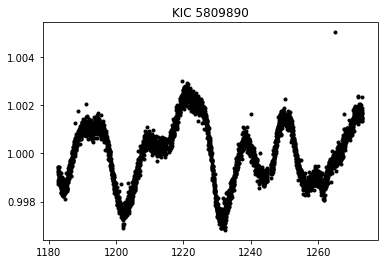

In [4]:
def load_file(filename):
    """Loads a TESS *spoc* FITS file and returns TIME, PDCSAP_FLUX"""
    hdu = fits.open(filename)
    time = hdu[1].data['TIME']
    flux = hdu[1].data['PDCSAP_FLUX']
    error = hdu[1].data['PDCSAP_FLUX_ERR']
    flux[flux == 0] = np.nan
    return time, flux, error

#interesting stars to try
filename = "https://archive.stsci.edu/missions/kepler/lightcurves/0058/005809890/kplr005809890-2012179063303_llc.fits"


# filename = 'https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00029831208-s01_tess_v1_lc.fits'
# filename = 'https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00077031414-s02_tess_v1_lc.fits'

print('Loading TESS data from archive.stsci.edu...')

time, flux, error = load_file(filename)

mask = np.where(np.isnan(flux)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
time = time[mask]                        #Sometimes there are holes in data filled with NaNs
flux = flux[mask]/np.mean(flux[mask])
error = error[mask]

plt.plot(time,flux,'k.')
plt.title("KIC 5809890");
plt.show()

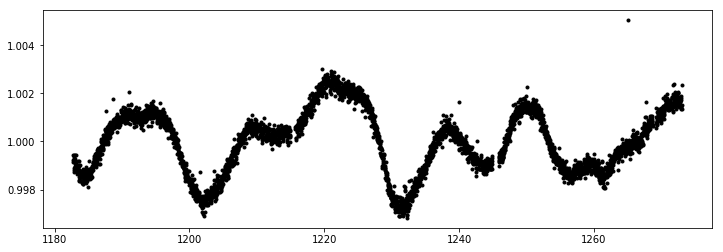

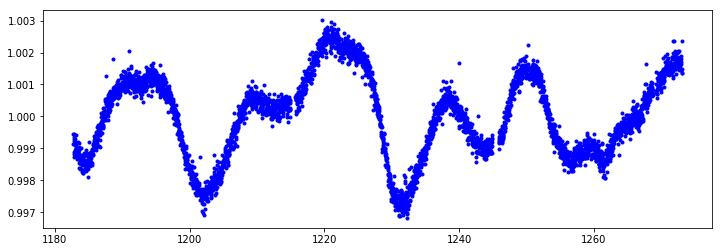

 Clearly, our Lightkurve detrending procedure doesn't do a great job with the
stellar variation + transit events


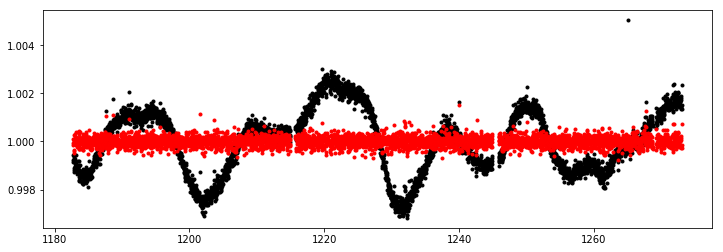

Let's try with Wotan


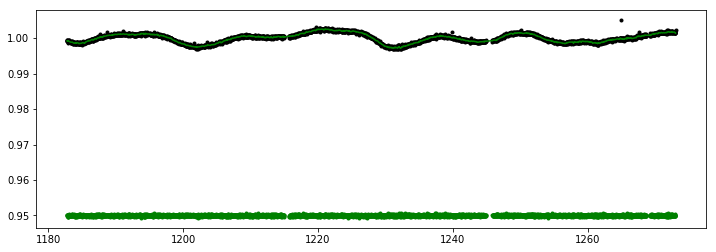

In [5]:
#clean up

#removing outliers with Chauvenet's criterion
t2,f2,fe2 = ChauventsCriteron(time,flux,error)

plt.figure(figsize=(12,4))
plt.plot(time,flux,'k.')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t2,f2,'b.')
plt.show()

#Detrending with Lightkurve
lc = lk.LightCurve(t2,f2,fe2)
bin_size = 10
cad = time[1]-time[0]
#now let's define a window size to smooth our data with:
window_size = int(3.0/cad) #number of data points in 5 hours
if (window_size % 2) == 0: #must be odd. If not, there will be an error
    window_size = window_size+1

detrended_lc = lc.flatten(window_length=window_size)#.bin(binsize=bin_size)
print(" Clearly, our Lightkurve detrending procedure doesn't do a great job with the")
print("stellar variation + transit events")

plt.figure(figsize=(12,4))
plt.plot(time,flux,'k.')
plt.plot(detrended_lc.time,detrended_lc.flux,'r.')
plt.show()

print("Let's try with Wotan")
#Detrending with Wotan
window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, method='biweight',robust=True)

nanmask = np.where(np.isnan(flatten_lc)==False)[0]
t2 = t2[nanmask]
f2 = f2[nanmask]
fe2 =fe2[nanmask]
flatten_lc = flatten_lc[nanmask]
trend_lc = trend_lc[nanmask]

t2_wotan,f2_wotan,fe2_wotan = ChauventsCriteron(t2,flatten_lc,fe2)
plt.figure(figsize=(12,4))
plt.plot(time,flux,'k.')
plt.plot(t2,trend_lc,'g')
plt.plot(t2_wotan,f2_wotan-0.05,'g.')
plt.show()

compare Lightkurve vs Wotan: 


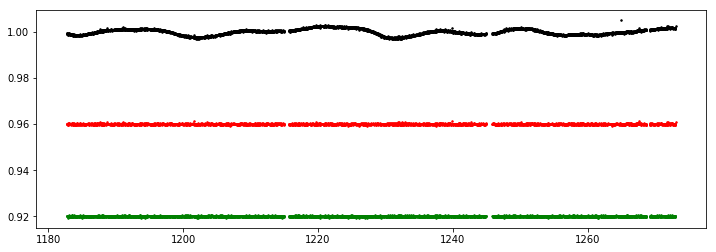

Zoom in on 12 day region
compare Lightkurve vs Wotan: 


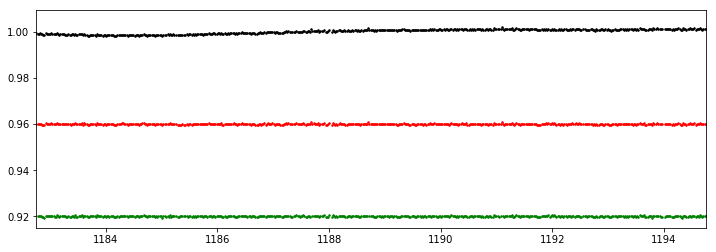

In [6]:
print("compare Lightkurve vs Wotan: ")
plt.figure(figsize=(12,4))
plt.plot(time,flux,'k.',markersize=3)
plt.plot(detrended_lc.time,detrended_lc.flux-0.04,'r.',markersize=3)
plt.plot(t2_wotan,f2_wotan-0.08,'g.',markersize=3)
plt.show()

print("Zoom in on 12 day region")

print("compare Lightkurve vs Wotan: ")
plt.figure(figsize=(12,4))
plt.plot(time,flux,'k.',markersize=3)
plt.plot(detrended_lc.time,detrended_lc.flux-0.04,'r.',markersize=3)
plt.plot(t2_wotan,f2_wotan-0.08,'g.',markersize=3)

plt.xlim(time[0],time[0]+12)
plt.show()

## Rapidly rotating stars are a problem...
## Idea: Use a Lomb-Scargle to identify a rotational period as a prior, then apply a gaussian process to fit a quasi-periodic kernal to the data


A decent Lomb-Scargle procedure can be found from AstroML. There is a version in Astropy as well but this gives different results which are troubling... Anywho, here's how you get AstroML installed:

```js
pip install AstroML
```

If you have a virtual environment:

```js
/Users/UserName/anaconda/envs/environment_name/bin/pip install AstroML
```

## (See Angus et al. 2018) 

https://watermark.silverchair.com/stx2109.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAmAwggJcBgkqhkiG9w0BBwagggJNMIICSQIBADCCAkIGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMTKtHOCP94BhDn4ciAgEQgIICE6k0o-kwWvLG16VJuWS0ZZPz30tifbW2rVYcC6XRMwGqbTX1FuDDkL5mM314Icwg4jCm8UTZIIPK_9Q3A12ORk0TBTJf6VN5iuoTkHGi5RpnFPFDDnfuUNnoGLg2lewExBlvii-GdH_VLxAScpaWOEtC9JK-Y_SVzszjWs_uQ0IzaeCpkaZz1nskSrQ9YuINahEuGRipeuDir_2zmMdhoDQgyuMbGKSZXAdIw-_nnbMG5Vu3R7HTZZ2sQXyATAJX2BzbpK2jPkqiHJQhpOeEMcgbrPXPABtpj7J4OKZdp9RqYEb11GEHPpwtPgTI2ags8BrvkSx2FoA8YCvawiwdyQzx_3wK7oqAsj5NLhBPMrIaca9M2XrgVi0QR86ChDfDYzyQg_g3-2mqkFxXfJb15dGqYMJ-mRrWr_kI4i4t7lf7I16bBX9pYecxEbnBp_W6u3usUAD5iDRL4_dxB41p1FG-ei5MmgpSlYI6-uJLXarAJPBfKfCw3HBmGjxHpnjgT7Vj7qpga81yBfnSJMFBLARcViBTXoyqTCsabAr_w_dYOO7L1A93ZDtXiSsBGDXKVC5DaMFpRzGrpElVTF6XN6X-aHSAa08yenD_cdxpzVx22cbpF6-_7rMBeEjoBIbl0O8huj3JBAgt28FNuSuLvLEqMArhDQDkd5MoMVzg9jYFN9NcS01lcybwR7vbEiIkNn_xoQ

## Instead of using the Biweight MidCorrelation method, let's try fitting a Quasi-Periodic Gaussian Process

First, let's get an estimate on this rotation period: 


        Use astropy.stats.LombScargle instead. [__main__]


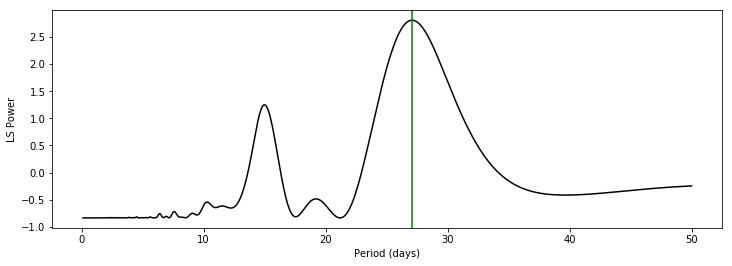

LS top peak period:  27.072972972972973  days


In [7]:
print("First, let's get an estimate on this rotation period: ")
from astroML.time_series import lomb_scargle

# Compute periodogram
minP=0.1
maxP=50

# period = 10 ** np.linspace(minP, maxP, 1000)
period = np.linspace(minP,maxP, 1000)
freq = 2.0 * np.pi / period
PS = lomb_scargle(time,flux, error,omega=freq, generalized=True)
Standpower = (PS-np.mean(PS))/np.std(PS)

plt.figure(figsize=(12,4))
plt.plot(period,Standpower,'k')
plt.axvline(x=period[np.argmax(Standpower)],color='g')
# plt.xlim(1,(2*np.pi/frequency)+2.5)
plt.ylabel("LS Power")
plt.xlabel("Period (days)")
plt.show()

print("LS top peak period: ",period[np.argmax(Standpower)]," days")


## I think in general, if a star's stellar rotation < 2 days, you can consider it "rapidly rotating".

Lets go ahead and apply GP

# In order to decide what level of correlation between data points we need to fit, we need to decide what a decent characteristic length scale is. Below, I try a few: 20, 5, 2 and 1.

## But before we do anything, we'll need to reduce our data size a bit. Currently, the length of our data arrays are 18317(2 minute cadences) which is a lot. Let's bin it down with a binsize of 60 minutes.

In [8]:
#custom binning function
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time))
    timefit = time[good]
    fluxfit = flux[good]
    errfit  = error[good]
    timemax = np.max(timefit)
    timemin = np.min(timefit)
    npoints = len(timefit)
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
    bintime = np.full((nbins,), np.nan)
    binflux = np.full((nbins,), np.nan)
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
        if tobin[0] != -1:
    #     inverse variance weighted means
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime))
    bintime = bintime[good2]
    binflux = binflux[good2]
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #these are annoying.


print(len(time))
binsize= 60.0/(60.0*24.0) 
bintime,binflux,binferror = Bin_func(time, flux,error,binsize)
print(len(bintime))

4243
2114


length scale:  20
Segment 1 of 1


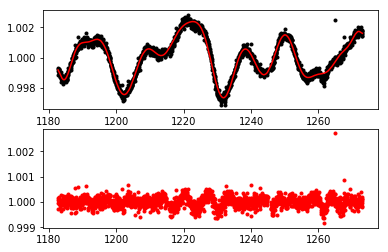

length scale:  10
Segment 1 of 1


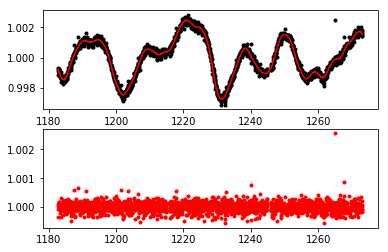

length scale:  5
Segment 1 of 1


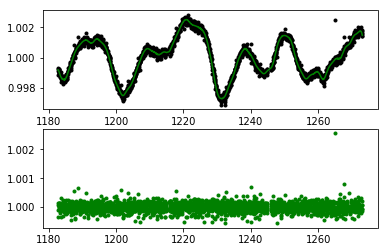

length scale:  2
Segment 1 of 1


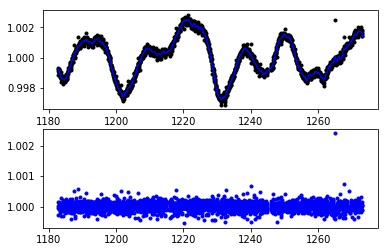

length scale:  1
Segment 1 of 1


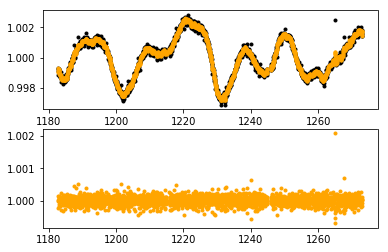

In [9]:
length_scale1 =20 #how close do data points have to be to be correlated?
print('length scale: ',length_scale1)
gpflatten_lc1, gptrend_lc1 = flatten(bintime,binflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale1,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(bintime, binflux, 'k.')
plt.plot(bintime,gptrend_lc1,'r-')
fig.add_subplot(212)
plt.plot(bintime,gpflatten_lc1,color='r',marker='.',linestyle='none')
plt.show()

length_scale1 =10 #how close do data points have to be to be correlated?
print('length scale: ',length_scale1)
gpflatten_lc1, gptrend_lc1 = flatten(bintime,binflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale1,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(bintime, binflux, 'k.')
plt.plot(bintime,gptrend_lc1,'r-')
fig.add_subplot(212)
plt.plot(bintime,gpflatten_lc1,color='r',marker='.',linestyle='none')
plt.show()


length_scale2 =5 #how close do data points have to be to be correlated?
print('length scale: ',length_scale2)
gpflatten_lc2, gptrend_lc2 = flatten(bintime,binflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale2,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(bintime, binflux, 'k.')
plt.plot(bintime,gptrend_lc2,'g-')
fig.add_subplot(212)
plt.plot(bintime,gpflatten_lc2,color='g',marker='.',linestyle='none')
plt.show()


length_scale3 =2 #how close do data points have to be to be correlated?
print('length scale: ',length_scale3)
gpflatten_lc3, gptrend_lc3 = flatten(bintime,binflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale3,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(bintime, binflux, 'k.')
plt.plot(bintime,gptrend_lc3,'b-')
fig.add_subplot(212)
plt.plot(bintime,gpflatten_lc3,color='b',marker='.',linestyle='none')
plt.show()

length_scale4 =1 #how close do data points have to be to be correlated?
print('length scale: ',length_scale4)
gpflatten_lc4, gptrend_lc4 = flatten(bintime,binflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale4,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(bintime, binflux, 'k.')
plt.plot(bintime,gptrend_lc4,color='orange',marker='.',linestyle='-')
fig.add_subplot(212)
plt.plot(bintime,gpflatten_lc4,color='orange',marker='.',linestyle='none')

plt.show()

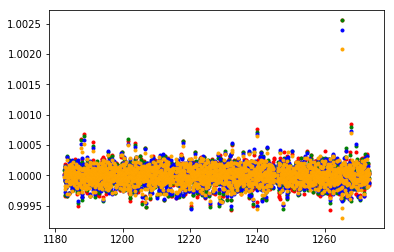

In [10]:
plt.plot(bintime,gpflatten_lc1,'r.')
plt.plot(bintime,gpflatten_lc2,'g.')
plt.plot(bintime,gpflatten_lc3,'b.')
plt.plot(bintime,gpflatten_lc4,color='orange',marker='.',linestyle='none')
plt.show()

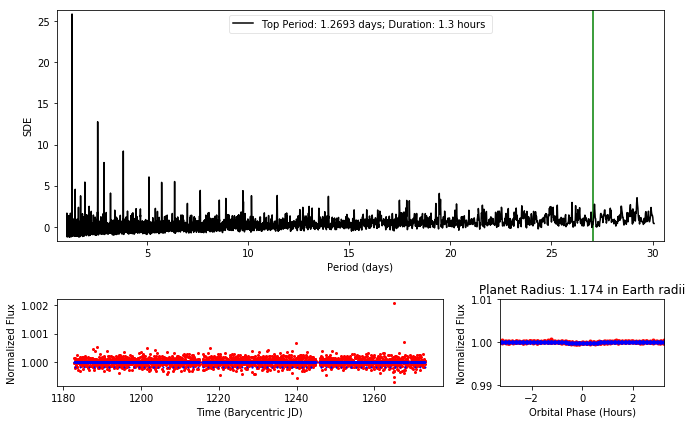

top LS period:  27.072972972972973 versus BLS recovered period:  1.2692946816627309


In [22]:
t = bintime; f=gpflatten_lc4 #length scale =1

R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm

R_star = 0.77# *Rad_sun
M_star = 0.82#*Mass_Sun

spacing = 0.02
fs = 9

minP=1.01
maxP= (max(bintime)-min(bintime)) #length of our light curve
minDur = 1.0/24.0
maxDur = 5.0/24.0

#creating list of orbital periods to model with
periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

durations = np.linspace(minDur,maxDur,25)

bls = BoxLeastSquares(t, f)
bls_power = bls.power(periods, durations)
bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)

#phase folding with best BLS model
index = np.argmax(bls_power.power); 
best_period = bls_power.period[index]; 
best_t0 = bls_power.transit_time[index];
BLS_depths=bls_power.depth[index]
BLS_dur = bls_power.duration[index]

#estimating planet radius determined by BLS
R_p = np.sqrt(BLS_depths)*R_star*R_sun/R_earth

#creating the best fit box model to our data
bls_model=bls.model(t,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])

p = best_period
x_fold = (t - best_t0 + 0.5*p) % p - 0.5*p


gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(gs1[:-1, :])
ax2 = fig.add_subplot(gs1[-1, :-1])
ax3 = fig.add_subplot(gs1[-1, -1])


ax1.axvline(period[np.argmax(Standpower)],color='g')
ax1.plot(bls_power.period, bls_SDE, color='k',rasterized=True, label='Top Period: '+str( np.round(best_period,4) )+" days; Duration: "+str(np.round(24*BLS_dur,3))+" hours ") #rounding period to 4 decimal places 
plt.xticks(np.arange(0.0, 31.0, 1.0))
ax1.set_xlabel("Period (days)")
ax1.set_xlim(np.min(bls_power.period)-0.5, np.max(bls_power.period)+0.5)
ax1.set_ylabel("SDE")
ax1.set_ylim(np.min(bls_SDE)-0.5, np.max(bls_SDE)+0.5)
ax1.legend(loc='best',fancybox=True,framealpha=0.5)

ax2.plot(t,f,c='red',markersize=4,marker='.',linestyle='none',zorder=1)
ax2.plot(t,bls_model,'b.',markersize=2)
# ax2.set_ylim(np.min(f)-spacing, np.max(f)+spacing)
ax2.set_xlabel("Time (Barycentric JD)")
ax2.set_ylabel("Normalized Flux") 

ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
ax3.plot(24*x_fold,f,c='red',markersize=6,marker='.',linestyle='none',zorder=1)
ax3.plot(24*x_fold,bls_model,'b.',markersize=5,label='BLS model')
ax3.set_xlabel("Orbital Phase (Hours)")
ax3.set_ylabel("Normalized Flux") 
ax3.set_ylim(np.min(bls_model)-spacing+0.01, np.max(bls_model)+spacing-0.01)
ax3.set_xticks(np.arange(-10,15,2)) #hours
ax3.set_xlim(-2.5*BLS_dur*24,2.5*BLS_dur*24)
gs1.tight_layout(fig)

plt.show()

print("top LS period: ", period[np.argmax(Standpower)], "versus BLS recovered period: ", best_period)



## Looks like we've sucessfully recovered Kepler-755 b (KIC 5809890) using a Quasi-periodic gaussian process combined with a Biweighted midcorrelation filter.
http://www.openexoplanetcatalogue.com/planet/Kepler-755%20b/

## What about without the QP GP and just with the Biweighted midcorrelation?

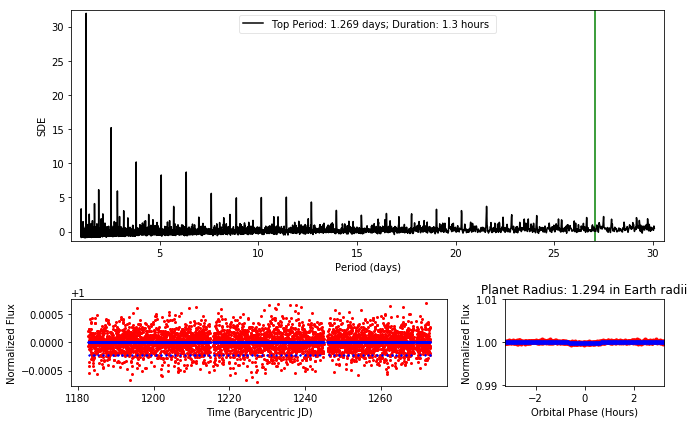

top LS period:  27.072972972972973 versus BLS recovered period:  1.2690044744493678


In [23]:
R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm


t=t2_wotan; f=f2_wotan #length scale =1
R_star = 0.77# *Rad_sun
M_star = 0.82#*Mass_Sun

spacing = 0.02
fs = 9

minP=1.01
maxP= (max(t)-min(t)) #length of our light curve
minDur = 1.0/24.0
maxDur = 5.0/24.0

#creating list of orbital periods to model with
periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

durations = np.linspace(minDur,maxDur,25)

bls = BoxLeastSquares(t, f)
bls_power = bls.power(periods, durations)
bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)

#phase folding with best BLS model
index = np.argmax(bls_power.power); 
best_period = bls_power.period[index]; 
best_t0 = bls_power.transit_time[index];
BLS_depths=bls_power.depth[index]
BLS_dur = bls_power.duration[index]

#estimating planet radius determined by BLS
R_p = np.sqrt(BLS_depths)*R_star*R_sun/R_earth

#creating the best fit box model to our data
bls_model=bls.model(t,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])

p = best_period
x_fold = (t - best_t0 + 0.5*p) % p - 0.5*p


gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(gs1[:-1, :])
ax2 = fig.add_subplot(gs1[-1, :-1])
ax3 = fig.add_subplot(gs1[-1, -1])


ax1.axvline(period[np.argmax(Standpower)],color='g')
ax1.plot(bls_power.period, bls_SDE, color='k',rasterized=True, label='Top Period: '+str( np.round(best_period,4) )+" days; Duration: "+str(np.round(24*BLS_dur,3))+" hours ") #rounding period to 4 decimal places 
plt.xticks(np.arange(0.0, 31.0, 1.0))
ax1.set_xlabel("Period (days)")
ax1.set_xlim(np.min(bls_power.period)-0.5, np.max(bls_power.period)+0.5)
ax1.set_ylabel("SDE")
ax1.set_ylim(np.min(bls_SDE)-0.5, np.max(bls_SDE)+0.5)
ax1.legend(loc='best',fancybox=True,framealpha=0.5)

ax2.plot(t,f,c='red',markersize=4,marker='.',linestyle='none',zorder=1)
ax2.plot(t,bls_model,'b.',markersize=2)
# ax2.set_ylim(np.min(f)-spacing, np.max(f)+spacing)
ax2.set_xlabel("Time (Barycentric JD)")
ax2.set_ylabel("Normalized Flux") 

ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
ax3.plot(24*x_fold,f,c='red',markersize=6,marker='.',linestyle='none',zorder=1)
ax3.plot(24*x_fold,bls_model,'b.',markersize=5,label='BLS model')
ax3.set_xlabel("Orbital Phase (Hours)")
ax3.set_ylabel("Normalized Flux") 
ax3.set_ylim(np.min(bls_model)-spacing+0.01, np.max(bls_model)+spacing-0.01)
ax3.set_xticks(np.arange(-10,15,2)) #hours
ax3.set_xlim(-2.5*BLS_dur*24,2.5*BLS_dur*24)
gs1.tight_layout(fig)

plt.show()

print("top LS period: ", period[np.argmax(Standpower)], "versus BLS recovered period: ", best_period)



## The orbital period is right on the money however published planet radius is 1.76 Earth radii which BLS totally underestimates. For reference, Mars is about 0.5 Earth radii.
## As an exercise, it would be interesting to see how TLS fairs. Try it out!